In [1]:
!pip install wandb

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader, Dataset
import os
import cv2
from skimage import io
from skimage import data
from skimage import filters
import glob, itertools
# Data Augmentation for Image Preprocessing
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, Cutout, ShiftScaleRotate, ToGray,
                            Resize,  ColorJitter, GaussianBlur, RandomBrightnessContrast)
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.nn.functional as F
import pydicom
import scipy
from skimage.exposure import equalize_adapthist
import tqdm
import logging
import torch.optim as optim
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

class clr:
    BOLD = '\033[1m'
    G = '\033[92m'
    Y = '\033[93m'
    R = '\033[91m'
    E = '\033[0m'
    
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(clr.BOLD+clr.G+'Using:'+clr.E, DEVICE)

Using: cuda


# dataset

In [3]:
# init base param
h, w = 224, 224

In [4]:
# pre-processing image (clahe)
def pre_img(img):
    img = img.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img)
    return img_clahe

# transform image 
transform = Compose([
    Resize(height=h, width=w, always_apply=True),
    Normalize(mean=0.449, std=0.226),
    HorizontalFlip(),
    VerticalFlip(),
    Rotate(),
#     ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    GaussianBlur(),
#     RandomRotation(limit=30),
#     RandomBrightnessContrast(),
    ToTensorV2()
])

In [5]:
class Dataset(Dataset):
    def __init__(self, root_dir, transform=None, label=None, option=None):
        self.root_dir = root_dir
        self.dataframe = pd.read_csv(f'{root_dir}/description.csv')
        self.transform = transform
        if label is not None:
            self.dataframe = self.dataframe[self.dataframe['Cancer'] == label]
        if (label == 0) & (option is not None):
            self.dataframe = self.dataframe[self.dataframe['Cancer'] == label].sample(2500)
#         if is_train:
#             self.dataframe = self.dataframe[]
        self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        image_path = f'{self.root_dir}/{self.dataframe.iloc[index].Path_save}'
        image = cv2.imread(image_path, 0)
        image = pre_img(image)
        if self.transform is not None:
            image_trans = self.transform(image=image)['image']
        else:
            image_trans = image
        label = self.dataframe.iloc[index]['Cancer']
        return image_trans, label

In [6]:
from torch.utils.data import DataLoader, random_split
def create_datasets(path, transform, label, option):
    dataset = Dataset(path, transform, label, option)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create data loaders for training and testing
#     train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    return train_dataset, test_dataset

In [7]:
# MIAS
train_mias_0, test_mias_0 = create_datasets('/kaggle/input/mias-roi-mammography', transform, label=0, option=None)
train_mias_1, test_mias_1 = create_datasets('/kaggle/input/mias-roi-mammography', transform, label=1, option=None)

# Inbreast
train_inbr_0, test_inbr_0 = create_datasets('/kaggle/input/inbreast-roi-mammography', transform, label=0, option=None)
train_inbr_1, test_inbr_1 = create_datasets('/kaggle/input/inbreast-roi-mammography', transform, label=1, option=None)

# DDSM
train_ddsm_0, test_ddsm_0 = create_datasets('/kaggle/input/mini-ddsm-roi-mammography', transform, label=0, option='ddsm')
train_ddsm_1, test_ddsm_1 = create_datasets('/kaggle/input/mini-ddsm-roi-mammography', transform, label=1, option='ddsm')

In [8]:
# Concatenate the datasets
train_dataset = ConcatDataset([train_mias_0, train_mias_1, train_inbr_0, train_inbr_1, train_ddsm_0, train_ddsm_1])
test_dataset = ConcatDataset([test_mias_0, test_mias_1, test_inbr_0, test_inbr_1, test_ddsm_0, test_ddsm_1])

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

#Create train dataset
train_ddsm = ConcatDataset([train_ddsm_0, train_ddsm_1])
ddsm_loader = DataLoader(train_ddsm, batch_size=32, shuffle=True)

train_mias = ConcatDataset([train_mias_0, train_mias_1])
mias_loader = DataLoader(train_mias, batch_size=32, shuffle=True)

train_inbreast = ConcatDataset([train_inbr_0, test_inbr_1])
inbreast_loader = DataLoader(train_inbreast, batch_size=32, shuffle=True)

# Single Test Dataset
test_ddsm = ConcatDataset([test_ddsm_0, test_ddsm_1])
test_ddsm = DataLoader(test_ddsm, batch_size=32, shuffle=True)

test_mias = ConcatDataset([test_mias_0, test_mias_1])
test_mias = DataLoader(test_mias, batch_size=32, shuffle=True)

test_inbreast = ConcatDataset([test_inbr_0, test_inbr_1])
test_inbreast = DataLoader(test_inbreast, batch_size=32, shuffle=True)

# DataLoader

Created dataloader, size trainloader: 149


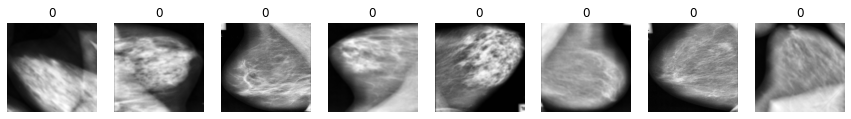

In [10]:
batch_size = 32

print('Created dataloader, size trainloader:', len(train_loader))

plt.figure(figsize=(15, 15))
for i, (img, label) in enumerate(train_dataset):
    plt.subplot(1,8,i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)
    plt.title(label.item())
    if i == 7:
        break

In [11]:
for k,(img,la) in enumerate(train_loader):
    if k == 2:
        break
    print(clr.R + f"Batch: {k}" + clr.E, "\n" +
          clr.R + "Image:" + clr.E, img.shape, "\n" +
          clr.R + "Label:" + clr.E, la, "\n" +
          "="*50)

Batch: 0 
Image: torch.Size([32, 1, 224, 224]) 
Label: tensor([0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        0, 0, 0, 1, 0, 1, 1, 0]) 
Batch: 1 
Image: torch.Size([32, 1, 224, 224]) 
Label: tensor([1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 0, 0, 1]) 


# Init model

In [12]:

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()

        x = self.relu(self.batch_norm2(self.conv1(x)))
        x = self.batch_norm2(self.conv2(x))

        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        print(x.shape)
        print(identity.shape)
        x += identity
        x = self.relu(x)
        return x


        
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=1):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        
def ResNet50(num_classes, channels=1):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)
    
def ResNet101(num_classes, channels=1):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes, channels=1):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)


# Train model

In [13]:
!mkdir /kaggle/working/model

In [14]:
# pass: 5ea6bd91c3e49f50e2842e8fc29f928eb0f5cd82
import wandb
!wandb login 5ea6bd91c3e49f50e2842e8fc29f928eb0f5cd82
wandb.init(project="RestNet_Final", entity="breast-cancer-kltn", name='final_test')

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: truongthicamly1412 (breast-cancer-kltn). Use `wandb login --relogin` to force relogin


In [15]:
net = ResNet50(2).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [16]:
# apply gpu to trainning
def data_to_device(img,label=None):
    if label != None:
        return img.to(DEVICE), label.to(DEVICE)
    else:
        return img.to(DEVICE)

In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# train
tmp = 0
for epoch in range(180):
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    for i, inp in enumerate(train_loader, 0):
        inputs, labels = inp
        inputs, labels = data_to_device(inputs, labels)
        optimizer.zero_grad()
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        total_samples += len(labels)
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        if i % 10 == 5:
            train_acc = running_corrects / total_samples
            train_loss = running_loss / 100
            print(f"[Epoch {epoch + 1}, Batch {i }] loss: {train_loss:.3f}, acc: {train_acc:.3f}")
            wandb.log({'loss':train_loss, 'accuracy':train_acc})
            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

    # Calculate F1-score, recall, and precision
    report = classification_report(all_labels, all_preds, output_dict=True)
    f1_score = report['weighted avg']['f1-score']
    recall = report['weighted avg']['recall']
    precision = report['weighted avg']['precision']
    wandb.log({'f1-score':f1_score, 'recall':recall, 'precision':precision})
    if f1_score > tmp:
        tmp = f1_score
        # Step 5: Save your trained model
        torch.save(net.state_dict(), "/kaggle/working/model/RestNet50.pt")

[Epoch 1, Batch 5] loss: 0.061, acc: 0.479
[Epoch 1, Batch 15] loss: 0.083, acc: 0.547
[Epoch 1, Batch 25] loss: 0.084, acc: 0.538
[Epoch 1, Batch 35] loss: 0.094, acc: 0.541
[Epoch 1, Batch 45] loss: 0.106, acc: 0.456
[Epoch 1, Batch 55] loss: 0.078, acc: 0.578
[Epoch 1, Batch 65] loss: 0.090, acc: 0.556
[Epoch 1, Batch 75] loss: 0.070, acc: 0.669
[Epoch 1, Batch 85] loss: 0.072, acc: 0.541
[Epoch 1, Batch 95] loss: 0.064, acc: 0.637
[Epoch 1, Batch 105] loss: 0.071, acc: 0.578
[Epoch 1, Batch 115] loss: 0.069, acc: 0.569
[Epoch 1, Batch 125] loss: 0.076, acc: 0.594
[Epoch 1, Batch 135] loss: 0.068, acc: 0.594
[Epoch 1, Batch 145] loss: 0.064, acc: 0.637
[Epoch 2, Batch 5] loss: 0.041, acc: 0.599
[Epoch 2, Batch 15] loss: 0.072, acc: 0.591
[Epoch 2, Batch 25] loss: 0.065, acc: 0.606
[Epoch 2, Batch 35] loss: 0.061, acc: 0.647
[Epoch 2, Batch 45] loss: 0.071, acc: 0.637
[Epoch 2, Batch 55] loss: 0.068, acc: 0.559
[Epoch 2, Batch 65] loss: 0.063, acc: 0.656
[Epoch 2, Batch 75] loss: 0.0

# Test

In [18]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
def test_acc(dataset, data_name):
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for data in dataset:
            images, labels = data
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = net(images)
            probabilities = F.softmax(outputs, dim=1)
            predicted = torch.argmax(probabilities, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(data_name)
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")

    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(cm)

    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    # Print the results
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

In [19]:
test_acc(train_loader, 'Dataset Train')

Dataset Train
Accuracy: 84.48%
Confusion Matrix:
[[1739  530]
 [ 208 2278]]
Precision: 0.8112535612535613
Recall: 0.916331456154465
F1-score: 0.8605969021533811


In [20]:
test_acc(test_loader, 'Dataset Test')

Dataset Test
Accuracy: 69.15%
Confusion Matrix:
[[336 233]
 [135 489]]
Precision: 0.6772853185595568
Recall: 0.7836538461538461
F1-score: 0.7265973254086181


In [21]:
test_acc(ddsm_loader, 'DDSM Dataset Train')

DDSM Dataset Train
Accuracy: 83.13%
Confusion Matrix:
[[1515  485]
 [ 219 1953]]
Precision: 0.8010664479081214
Recall: 0.899171270718232
F1-score: 0.847288503253796


In [22]:
test_acc(test_ddsm, 'DDSM Dataset Test')

DDSM Dataset Test
Accuracy: 66.38%
Confusion Matrix:
[[281 219]
 [132 412]]
Precision: 0.652931854199683
Recall: 0.7573529411764706
F1-score: 0.7012765957446808


In [23]:
test_acc(mias_loader, 'Mias Dataset Train')

Mias Dataset Train
Accuracy: 38.28%
Confusion Matrix:
[[ 70 146]
 [ 12  28]]
Precision: 0.16091954022988506
Recall: 0.7
F1-score: 0.2616822429906542


In [24]:
test_acc(test_mias, 'Mias Dataset Test')

Mias Dataset Test
Accuracy: 37.88%
Confusion Matrix:
[[16 39]
 [ 2  9]]
Precision: 0.1875
Recall: 0.8181818181818182
F1-score: 0.30508474576271183


In [25]:
test_acc(inbreast_loader, 'Inbreast Dataset Train')

Inbreast Dataset Train
Accuracy: 65.57%
Confusion Matrix:
[[27 26]
 [16 53]]
Precision: 0.6708860759493671
Recall: 0.7681159420289855
F1-score: 0.7162162162162162


In [26]:
test_acc(test_inbreast, 'Inbreast Dataset Test')

Inbreast Dataset Test
Accuracy: 63.86%
Confusion Matrix:
[[ 4 10]
 [20 49]]
Precision: 0.8305084745762712
Recall: 0.7101449275362319
F1-score: 0.7656250000000001


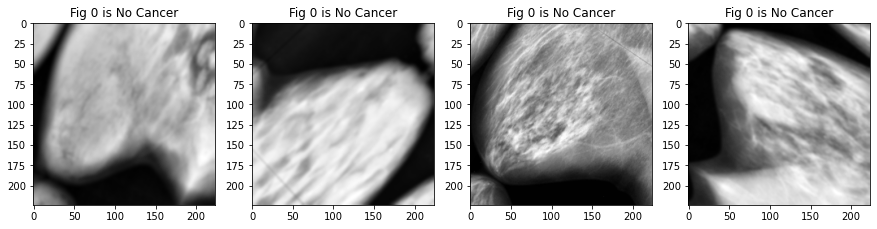

In [27]:
classes = ['No Cancer','Cancer']
list_pred_id=[]
list_pred_cancer=[]
net.eval()
with torch.no_grad():
    fig,ax = plt.subplots(1,4,figsize=(15,15))
    for k,(img_test,pred_id) in enumerate(test_dataset):
        ax_idx = ax[k]
        ax_idx.imshow(img_test.permute(1,2,0),cmap=plt.cm.gray)
        pred = net(img_test.type(torch.cuda.FloatTensor).unsqueeze(0))
        softmax=nn.Softmax(dim=1)
        final_pred = softmax(pred)
        predicted = classes[final_pred[0].argmax(0)]
        list_pred_id.append(pred_id)
        list_pred_cancer.append(final_pred[0].argmax(0).item())
        ax_idx.set_title(f"Fig {pred_id} is {predicted}")
        if k == 3:
            break